In [1]:
from typing import Callable, Any

import jax
import jax.numpy as jnp
import numpy as np
import flax.linen as nn
from flax import struct
import optax
import tensorflow_datasets as tfds

# jax.config.update('jax_platform_name', 'cpu')

key = jax.random.PRNGKey(0)

/home/khromykhla/Apps/anaconda3/envs/flax/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
Array = jnp.ndarray
Layers = tuple[int, ...]
RNG = jax.random.PRNGKey
Activation = Callable[[Array], Array]

In [3]:
def mlp(hid_dim, out_dim):
    return nn.Sequential([
        nn.Dense(hid_dim),
        nn.LayerNorm(),
        jax.nn.relu,
        nn.Dense(out_dim)
    ])

class CNN(nn.Module):
    emb_dim: int
    depths: Layers
    kernels: Layers
    strides: Layers

    @nn.compact
    def __call__(self, img):
        prefix = img.shape[:-3]
        gen = zip(self.depths, self.kernels, self.strides)
        x = img / 255.
        for d, k, s in gen:
            x = nn.Conv(d, (k, k), s, padding='valid')(x)
            x = nn.LayerNorm()(x)
            x = jax.nn.relu(x)
        return x.reshape(prefix + (-1,))

In [4]:
def random_crop(rng,
                img,
                crop_size
                ):
    pad = (crop_size, crop_size)
    nopad = (0, 0)
    pad_with = 2 * (pad,) + (nopad,)
    crop = jax.random.randint(rng, (2,), 0, 2 * crop_size + 1)
    crop = jnp.concatenate([crop, jnp.zeros(1)], dtype=jnp.int32)
    padded = jnp.pad(img, pad_with, mode='edge')
    return jax.lax.dynamic_slice(padded, crop, img.shape)

aug_v = lambda rng, img, size: jax.vmap(random_crop, in_axes=(0,0,None))(jax.random.split(rng, img.shape[0]), img, size)

In [5]:
class BYOL(nn.Module):
    encoder: nn.Module
    projector: nn.Module
    predictor: nn.Module
    classifier: nn.Module

    @nn.compact
    def __call__(self, img):
        emb = self.encoder(img)
        g = self.projector(emb)
        q = self.predictor(g)
        cl = self.classifier(jax.lax.stop_gradient(g))
        # cl = self.classifier(jax.lax.stop_gradient(emb))
        return {
            'embedding': emb,
            'projection': g,
            'prediction': q,
            'classification': cl
        }
        

In [6]:
from typing import Any

from flax import struct
import optax

class TrainingState(struct.PyTreeNode):
    params: Any
    target_params: Any
    optim_state: Any
    rng: Any
    step: Any

    update_fn: optax.TransformUpdateFn = struct.field(pytree_node=False)
    target_update: Any = struct.field(pytree_node=False)

    def update(self, grad):
        updates, state = self.update_fn(grad, self.optim_state, self.params)
        params = optax.apply_updates(self.params, updates)
        target_params = optax.incremental_update(params, self.target_params, self.target_update)
        return self.replace(params=params,
                            target_params=target_params,
                            optim_state=state,
                            step=self.step + 1)

    @classmethod
    def init(cls, rng, params, optim, target_update):
        state = optim.init(params)
        return cls(params, params, state, rng, 0, optim.update, target_update)

In [7]:
def byol_fn(net):
    def loss_fn(params, target_params, rng, img, label):
        k1, k2 = jax.random.split(rng)
        v1 = aug_v(k1, img, 4)
        v2 = aug_v(k2, img, 4)

        def f(v, vp):
            out = net.apply(params, v)
            tout = net.apply(target_params, vp)
            unsup_loss = optax.cosine_distance(out['prediction'], tout['projection']).mean()
            logits = out['classification']
            ce_loss = optax.softmax_cross_entropy_with_integer_labels(logits, label).mean()
            accuracy = (logits.argmax(-1) == label).mean()
            return unsup_loss + ce_loss, {
                'accuracy': accuracy,
                'ce_loss': ce_loss,
                'un_loss': unsup_loss,
                }
        return jax.tree_util.tree_map(lambda x,y: (x+y)/2, f(v1, v2), f(v2,v1))

    def step_fn(state, batch):
        params = state.params
        target_params = state.target_params
        rng, subkey = jax.random.split(state.rng)

        grad, metrics = jax.grad(loss_fn, has_aux=True)(params, target_params, subkey, batch[0], batch[1])
        state = state.update(grad)
        metrics.update(grad_norm=optax.global_norm(grad))

        return state.replace(rng=rng), metrics
    
    return step_fn
        
    

In [8]:
emb_dim = 128
depths = (48, 48, 48, 48)
kernels = (3, 3, 3, 3)
strides = (2, 1, 1, 1)

net = BYOL(
    encoder=CNN(emb_dim, depths, kernels, strides),
    projector=mlp(1024, emb_dim),
    predictor=mlp(1024, emb_dim),
    classifier=nn.Dense(10)
)
dummy_img = jnp.ones((32, 32, 3), dtype=jnp.uint8)
tout, params = net.init_with_output(key, dummy_img)
optim = optax.adamw(1e-3)
state = TrainingState.init(key, params, optim, 1e-3)
step = jax.jit(byol_fn(net))

ds = tfds.load('cifar10', split='all', as_supervised=True)
ds = ds.batch(256, drop_remainder=True).cache().repeat().as_numpy_iterator()

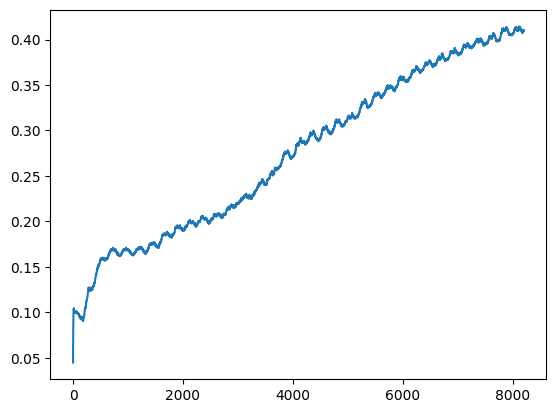

In [ ]:
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output
deq = deque(maxlen=100)
logs = []
for batch in ds:
    state, met = step(state, batch)
    deq.append(met['accuracy'].item())
    logs.append(np.mean(deq))
    clear_output(wait=True)
    plt.plot(logs)
    plt.show()